# Data Wrangling

## Data Gathering

This is the first step of collecting data from different sources. For this project there are three data sources. These are: 

<ol>
    <li>Twitter archive of tweets from WeRateDogs Twitter handle. Tweets have been analyzed and enhanced. The enhanced archive is available <a href="https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv">here</a></li>
    <li>Every dog image of WeRateDogs Twitter archive has been analyzed through a neural network that can classify breeds of dogs. That image prediction file is available <a href="https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5bf60c69_image-predictions-3/image-predictions-3.tsv">here</a></li>
    <li>Finally each tweet's retweet count and link count are metrics of interest. That data is retrieved using Twitter's API
</ol>
        


In [1]:
import requests
import os
import re
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data_dir = "data"
# Creates the directory to store data files if it does not exist

if not os.path.exists(data_dir):
    try:
        os.mkdir(data_dir)
    except OSError:
        print ("Creation of the directory: %s failed" % data_dir)
    else:
        print ("Successfully created the directory: %s " % data_dir)
else:
    print("Directory: %s already exists" % data_dir)


Successfully created the directory: data 


For the first two data sources I use Python's `request` object and related API to download the file. As this process is similar for first two data sources, I refactor common code into Python functions.

In [3]:
'''
Parses URL to get the last component from URL string and returns a tuple containing
1. File name without extension
2. File extension
'''
def parse_file_name(url):
    file_name, file_ext = url.split("/")[-1].split(".")
    return (file_name, file_ext)



In [4]:
'''
Downloads file from given url location
After download it stores downloaded data into a delimted file and stores it in data_dir
Delimiter character can be passed in a parameter
'''
def download_file(url, data_dir, input_field_sep=',', output_field_sep=None):
    r = requests.get(url)
    if r.status_code != 200: # Failure to download file
        print("File download from %s fails with status code: %d" % (url, r.status_code))
    else:

        input_file_name, input_file_ext = parse_file_name(url)
        output_file_name = input_file_name
        
        # Output file extension is named based on ouput field separator
        # If no separator is specified then input file extension is used for output as well
        # For comma output file extension is csv
        # For tab output file extension is tsv
        # Otherwise output file extension is txt
        if output_field_sep is None:
            output_file_ext = input_file_ext
        elif output_field_sep == ',':
            output_file_ext = 'csv'
        elif output_field_sep == '\t':
            output_file_ext = 'tsv'
        else:
            output_file_ext = 'txt'
            
        
        print("Downloading file: %s" % url.split("/")[-1])
        with open("{data_dir}/{output_file_name}.{output_file_ext}"\
              .format(data_dir=data_dir, output_file_name=output_file_name, output_file_ext=output_file_ext), "w") as fp:
            for line in r.text.split('\n'):
                # If output field separator is None then use the same separator as input data 
                if output_field_sep is None:
                    delimited_line = line
                else:
                    delimited_line = line.replace(input_field_sep, output_field_sep)
                fp.write(delimited_line + '\n') 
                
        print("Completed downloading file: %s.%s" % (output_file_name, output_file_ext))
        

## Dowloading image predictions file

In [5]:
prediction_url = "https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5bf60c69_image-predictions-3/image-predictions-3.tsv"
# In input record, fields are tab separated. It is converted to csv file so all dataframes can be read uniformly
download_file(prediction_url, data_dir, input_field_sep='\t', output_field_sep=',')



Completed downloading file: image-predictions-3.csv


In [6]:
# Load prediction data into a dataframe
prediction_df = pd.read_csv('data/image-predictions-3.csv')

## Downloading enhanced twitter archive

In [7]:

twitter_archive_url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv"
# Data is already comma delimited. So there is no need to do any transformation
download_file(twitter_archive_url, data_dir) 
    

Completed downloading file: twitter-archive-enhanced.csv


## Downloading retweet data using twitter API


In [8]:
import tweepy
import configparser

# Reading configuration file to get secret keys & tokens
config = configparser.ConfigParser()
config.read('tweeter_config.ini')
config.sections()

# Setting up - keys & access tokens
consumer_key = config['TWITTER']['CONSUMER_KEY']
consumer_secret = config['TWITTER']['CONSUMER_SECRET']
access_token = config['TWITTER']['ACCESS_TOKEN']
access_secret = config['TWITTER']['ACCESS_SECRET']

In [9]:

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

Before I can use Twitter's API to download tweet data, I need to use pandas to read enhanced twitter archive so that I can use tweet IDs from that dataframe. 

In [10]:
# Load enhanced twitter archive in panda dataframe
twitter_enhanced_df = pd.read_csv("%s/twitter-archive-enhanced.csv" % data_dir)
twitter_enhanced_df.head(5)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [11]:
'''
Downloads Twitter data using API call
'''
def download_tweets(tweet_ids, data_dir, download_file_name, mode="w"):
    print("Requested data for %d tweets" % len(tweet_ids))
    with open("%s/%s" % (data_dir, download_file_name), encoding='utf8', mode=mode) as fp:
        tweets = api.statuses_lookup(tweet_ids)
        print("Retrieved data for %d tweets" % len(tweets))
        for tweet in tweets:
            # Parsing data source field to get the device name
            # Hoping to do some analysis based on device type
            soup = BeautifulSoup(tweet._json['source'], 'lxml')
            tweet_json = json.dumps(
                {'tweet_id' : int(tweet._json['id']),
                 'source' : re.split(r'\s+', soup.a.text)[-1].lower(), 
                 'retweet_count' : int(tweet._json['retweet_count']),
                 'favorite_count' : int(tweet._json['favorite_count']),
                 'followers_count' : int(tweet._json['user']['followers_count'])
                })
            fp.write(tweet_json + '\n')

In [12]:

from bs4 import BeautifulSoup
            
tweet_count = twitter_enhanced_df['tweet_id'].count()
print("Total number of tweets: %d" % tweet_count)

for batch_id, i in enumerate(range(0, tweet_count, 100)):
    print("Processing batch: %d" % (batch_id + 1))
    if batch_id == 0: # First batch so overwrite any existing file
        mode = "w"
    else:
        mode = "a" # For subsequent calls append data to file
    download_tweets(
        twitter_enhanced_df['tweet_id'][batch_id * 100 : (batch_id + 1) * 100].tolist(), 
        data_dir, 
        "tweet_data.json", 
        mode)


Total number of tweets: 2356
Processing batch: 1
Requested data for 100 tweets
Retrieved data for 98 tweets
Processing batch: 2
Requested data for 100 tweets
Retrieved data for 96 tweets
Processing batch: 3
Requested data for 100 tweets
Retrieved data for 97 tweets
Processing batch: 4
Requested data for 100 tweets
Retrieved data for 99 tweets
Processing batch: 5
Requested data for 100 tweets
Retrieved data for 100 tweets
Processing batch: 6
Requested data for 100 tweets
Retrieved data for 98 tweets
Processing batch: 7
Requested data for 100 tweets
Retrieved data for 100 tweets
Processing batch: 8
Requested data for 100 tweets
Retrieved data for 99 tweets
Processing batch: 9
Requested data for 100 tweets
Retrieved data for 99 tweets
Processing batch: 10
Requested data for 100 tweets
Retrieved data for 99 tweets
Processing batch: 11
Requested data for 100 tweets
Retrieved data for 100 tweets
Processing batch: 12
Requested data for 100 tweets
Retrieved data for 100 tweets
Processing batch

A point to note that batching 100 tweet IDs and calling the API once for every batch of 100 tweet IDs makes is <b> huge</b> improvement to data gathering stage. Downloading 2500+ tweets can be completed in less than a minute. 

From the log above it is apparent that there are times when data of all tweet IDs are not available. These tweet IDs are collected and another attempt is made using missing tweet IDs to retrieve their data.

### Making a final attempt to retrieve the tweet IDs which didn't arrive during API calls

In [13]:
# Get all tweet IDs from enhaced file
tweet_data_df = pd.read_json("data/tweet_data.json", lines=True)

# Left outer join with data retrieved using twitter API calls
df_combined = twitter_enhanced_df.merge(tweet_data_df, how='left', indicator=True, on='tweet_id')

# Make a list of tweets which can not be retrieved using API call
error_list = df_combined[df_combined['_merge'] == 'left_only']['tweet_id'].tolist()

# Make another attempt
download_tweets(
    error_list, 
    data_dir, 
    "tweet_data.json", 
    "a")

Requested data for 16 tweets
Retrieved data for 0 tweets


Above <b>16</b> tweets could not be retrieved even after making a separate attempt. Most probably those 16 tweets no longer exists. 

## Data Assessment

### Visual Assessment

I am going to use few pandas functions to do the initial visual assesment. The objective of my visual assessment is to understand the dataframes, how they are related, meaning of each field and also to note down any inconsistent or dirty data that can be identified by opening the file(s) in Google sheet or by running few Pandas dataframe functions. 

Tools used for this stage are 
<ul>
    <li> Goggle sheet</li>
    <li> Pandas dataframe functions like head, tail, info, value_counts, describe</li>
</ul>

None of the files are big. So opening them up using a spreadsheet program is a task that can be accomplished easily.
    
I have three dataframes
<ol>
    <li>twitter_enhanced_df: Enhanced twitter archive</li>
    <li>tweet_data_df: Some metrics like retweet count , favorite count about every tweet</li>
    <li>prediction_df: classification of dogs by tweet ID using neural network</li>
</ol>

In [14]:
prediction_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [15]:
prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


`prediction_df` columns:
- **tweet_id**: the unique identifier for each tweet
- **jpg_url**: URL of the iamge of the dog
- **img_nume**: Image number
- **p1**: algorithm's #1 classification of the dog
- **p1_conf**: confidence factor for the above classification
- **p1_dog**: whether or not the #1 prediction is a breed of dog
- **p2**: algorithm's #2 classification of the dog
- **p2_conf**: confidence factor for the above classification
- **p2_dog**: whether or not the #2 prediction is a breed of dog
- **p3**: algorithm's #3 classification of the dog
- **p3_conf**: confidence factor for the above classification
- **p3_dog**: whether or not the #3 prediction is a breed of dog


In [16]:
prediction_df.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
888,699079609774645248,https://pbs.twimg.com/media/CbOhMUDXIAACIWR.jpg,3,schipperke,0.667324,True,Chesapeake_Bay_retriever,0.119550,True,kelpie,0.097600,True
824,693231807727280129,https://pbs.twimg.com/media/CZ7aplIUsAAq-8s.jpg,1,vizsla,0.876413,True,Chesapeake_Bay_retriever,0.078400,True,Rhodesian_ridgeback,0.032194,True
1753,824663926340194305,https://pbs.twimg.com/media/C3HLd0HXUAAUI2b.jpg,1,English_setter,0.526488,True,golden_retriever,0.402815,True,Irish_setter,0.034418,True
700,684800227459624960,https://pbs.twimg.com/media/CYDmK7ZVAAI_ylL.jpg,1,miniature_schnauzer,0.294457,True,Norfolk_terrier,0.161885,True,West_Highland_white_terrier,0.120992,True
306,671528761649688577,https://pbs.twimg.com/media/CVG_2I-WIAASKSS.jpg,1,Doberman,0.782626,True,black-and-tan_coonhound,0.109678,True,Gordon_setter,0.052110,True


In [17]:
prediction_df.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [18]:
prediction_df[prediction_df.p1_dog == False].head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False


In [19]:
# Additional assessment for prediction records having image_num > 1
prediction_df[prediction_df.img_num > 1].head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
144,668623201287675904,https://pbs.twimg.com/media/CUdtP1xUYAIeBnE.jpg,4,Chihuahua,0.708163,True,Pomeranian,0.091372,True,titi,0.067325,False
312,671547767500775424,https://pbs.twimg.com/media/CVHRIiqWEAAj98K.jpg,2,Loafer,0.255088,False,platypus,0.090019,False,cowboy_boot,0.066536,False
315,671735591348891648,https://pbs.twimg.com/media/CVJ79MzW4AEpTom.jpg,2,stone_wall,0.271121,False,Irish_wolfhound,0.063078,True,poncho,0.048226,False
319,671768281401958400,https://pbs.twimg.com/media/CVKZsHtWwAA6gPj.jpg,2,Chihuahua,0.500373,True,French_bulldog,0.112796,True,Italian_greyhound,0.062893,True
345,672272411274932228,https://pbs.twimg.com/media/CVRkLuJWUAAhhYp.jpg,2,pug,0.914685,True,Norwegian_elkhound,0.014982,True,Siamese_cat,0.009221,False


I inspected few URLs randomly e.g. tweetID = 668623201287675904 image URL = https://pbs.twimg.com/media/CUdtP1xUYAIeBnE.jpg
These appear to be picture of dog(s). 

Visual observation about *prediction_df*

* File could be open in the spreadsheet
* 2075 number of records found
* In most cases `img_num = 1`. May need to do additional assessment where `img_num > 1`
* There are records for which the pictures do not correspond to a dog e.g. tweet_id = 666051853826850816 having the image of <a href="https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg">box turtle</a> So this dog classification data where `p1_dog or p2_dog or p3_dog = False` can't be used if popularity of a specific breed of dog is indicated by number of retweets or "likes"

In [20]:
twitter_enhanced_df.head()


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


`twitter_enhanced_df` columns:
- **tweet_id**: the unique identifier for each tweet
- **in_reply_to_status_id**: Nullable. If the represented Tweet is a reply, this field will contain the integer representation of the original Tweet’s ID
- **in_reply_to_user_id**: Nullable. If the represented Tweet is a reply, this field will contain the integer representation of the original Tweet’s author ID. This will not necessarily always be the user directly mentioned in the Tweet.
- **timstamp**: Timestamp of the tweet
- **source**: Utility used to post the Tweet, as an HTML-formatted string. Tweets from the Twitter website have a source value of `web`
- **text**: Actual tweet
- **retweeted_status_id**: Users can amplify the broadcast of Tweets authored by other users by retweeting . Retweets can be distinguished from typical Tweets by the existence of a retweeted_status attribute
- **retweeted_status_user_id**:
- **retweeted_status_timestamp**: timestamp of the tweet which is retweeted here
- **expanded_url**: 
- **rating_numerator**: Numerator of rating given to dog
- **rating_denominator**: Denominator of the ratings given to dog
- **name**: name of the dog as it appears in the tweet
- **doggo**: Classification of the dog based on dogtionary
- **floffer**: Classification of the dog based on dogtionary
- **pupper**: Classification of the dog based on dogtionary
- **puppo**: Classification of the dog based on dogtionary


In [21]:
twitter_enhanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [22]:
twitter_enhanced_df.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [23]:
twitter_enhanced_df.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [24]:
twitter_enhanced_df.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [25]:
twitter_enhanced_df.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [26]:
twitter_enhanced_df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1431,697516214579523584,NaN,NaN,2016-02-10 20:23:19 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Say hello to Pherb. He does parkour. 9/10 http...,NaN,NaN,NaN,https://vine.co/v/i1LriMBmX6W,9,10,Pherb,None,None,None,None
1185,718613305783398402,NaN,NaN,2016-04-09 01:35:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Carper. He's a Tortellini Angiosperm. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/718613305...,11,10,Carper,None,None,None,None
1942,673711475735838725,NaN,NaN,2015-12-07 03:51:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",🎶 HELLO FROM THE OTHER SIIIIIIIIDE 🎶 10/10 htt...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673711475...,10,10,None,None,None,None,None
2315,666691418707132416,NaN,NaN,2015-11-17 18:56:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Christoper. He is a spotted Penne. Can...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666691418...,8,10,Christoper,None,None,None,None
1530,690021994562220032,NaN,NaN,2016-01-21 04:03:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Say hello to Geoff (pronounced ""Kyle""). He acc...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/690021994...,10,10,Geoff,None,None,None,None


* This dataframe contains 2356 records
* There are 181 not null values in `retweeted_status_id` field. This means that this dataframe contains 181 retweets out of total 2356 tweets listed in the file. These retweets may have to be removed if the analysis involves only tweets
* These retweets need to be filtered.
* `dog_stage` data seems to be very sparse. In majroity cases these columns contain `None`
* Opening the file in spreadsheet program shows few other data 
    - Dog name column often contain meaningless names or trunacted names e.g. dog name for the tweet ID = 668171859951755264 Here the actual dog name should be "Alfanso"
    - Tweet timestamp column contains +0000 It doesn't represent time zone. So its presence in the file is misleading.



In [27]:
tweet_data_df.head(5)

,favorite_count,followers_count,retweet_count,source,tweet_id
0,18383,7789116,2344,iphone,876484053909872640
1,20732,7789116,3111,iphone,886366144734445568
2,0,7789116,78,iphone,877611172832227328
3,21272,7789116,3395,iphone,888078434458587136
4,41208,7789116,8403,iphone,891689557279858688


`tweet_data_df` columns:
- **tweet_id**: the unique identifier for each tweet
- **favorite_count**: Number if likes for the tweet
- **followers_count**: Number of followers of the twitter handle `weratedogs`. I included this field hoping to do some analysis of follower count of the twitter handle over time
- **retweet_count**: Number of retweets of the given tweet
- **source**: Utility used to post the Tweet, as an HTML-formatted string. Tweets from the Twitter website have a source value of `web`. This field a cleaned up version of `source` field available from Twitter Json. 
    

In [28]:
tweet_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 5 columns):
favorite_count     2340 non-null int64
followers_count    2340 non-null int64
retweet_count      2340 non-null int64
source             2340 non-null object
tweet_id           2340 non-null int64
dtypes: int64(4), object(1)
memory usage: 91.5+ KB


* This dataframe contains 2340 entries. It is smaller by 16 records compared to `twitter_enhanced_df` as my attempt to get retweet & favorite count didn't result in success for 16 records.
* source is programatically cleaned


### Programatic Assessment

Visual analysis provides high level information about each data source. Next each dataframe is assessed using Python and Pandas. During this stage, I make a list of data cleanliness and structural issues along the way.
Correction of cleanliness and structural issues will be addressed in the next section.

In [29]:
twitter_enhanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [30]:
twitter_df_count = len(twitter_enhanced_df.index)
print("Number of records in twitter_enhanced_df = %d" % twitter_df_count)
print("Count of records in timestamp column having values ending in four trailing zeros = %d" % len(twitter_enhanced_df.timestamp.apply(lambda x: x.endswith("0000")).index))
print("Number of duplicated records in twitter_enhanced_data = %d" % twitter_enhanced_df.duplicated().sum())
reply_count = len(twitter_enhanced_df[np.invert(twitter_enhanced_df['in_reply_to_status_id'].isnull())].index)
print("Number of reply tweets = %d" % reply_count)
retweet_count = len(twitter_enhanced_df[np.invert(twitter_enhanced_df['retweeted_status_id'].isnull())].index)
print("Number of retweets = %d" % retweet_count)
print("Number of records in twitter_enhanced_df excluding replies & retweets = %d" % (twitter_df_count - reply_count - retweet_count))


Number of records in twitter_enhanced_df = 2356
Count of records in timestamp column having values ending in four trailing zeros = 2356
Number of duplicated records in twitter_enhanced_data = 0
Number of reply tweets = 78
Number of retweets = 181
Number of records in twitter_enhanced_df excluding replies & retweets = 2097


* All data values in `timestamp` field contain trailing `0000`. Also it is beneficial to define `timestamp` field as `datetime` datatype instead of string.
* Reply and retweets need to be removed for this analysis.

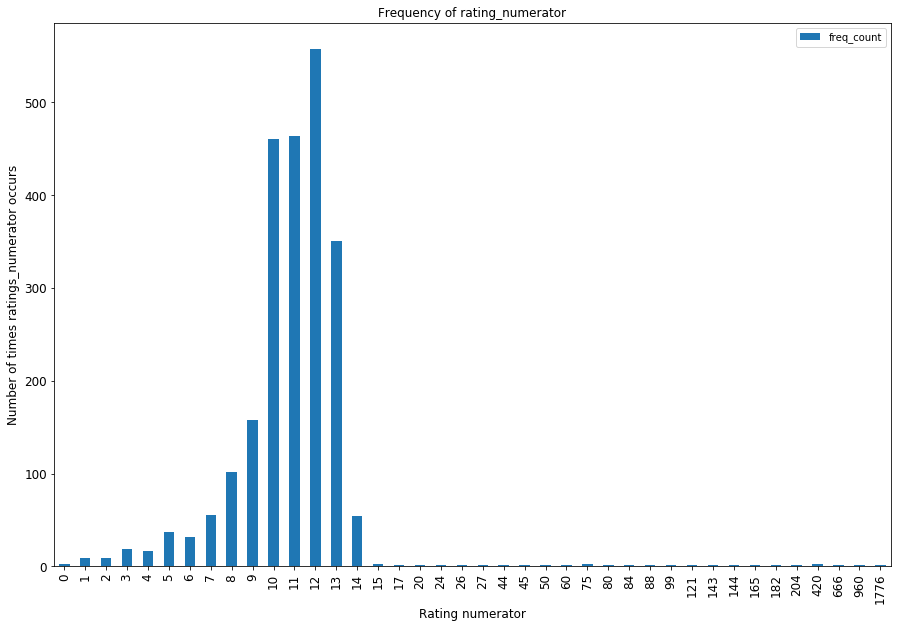

In [31]:
rating_numerator_df = \
ax = pd.DataFrame(twitter_enhanced_df.rating_numerator.value_counts())\
.reset_index()\
.rename(columns={'index': 'rating_numerator', 'rating_numerator': 'freq_count'})\
.sort_values(by=['rating_numerator'])[['rating_numerator', 'freq_count']]\
.set_index('rating_numerator')\
.plot\
.bar(figsize=(15,10),legend=True,fontsize=12, title='Frequency of rating_numerator');

ax.set_ylabel("Number of times ratings_numerator occurs", fontsize=12)
ax.set_xlabel("Rating numerator", fontsize=12);


Above histogram shows that `rating_numerator` values 
* Have a long tail with some of them having very high value like 666, 960, 1776. These can be because of bug which analyzed the text field and parsed rating values
* Majority of the dog pictures are rated between 0 - 14. 

In [32]:
rating_denominator_df = \
pd.DataFrame(twitter_enhanced_df.rating_denominator.value_counts())\
.reset_index()\
.rename(columns={'index': 'rating_denominator', 'rating_denominator': 'freq_count'})\
.sort_values(by=['rating_denominator'])[['rating_denominator', 'freq_count']]\
.set_index('rating_denominator')
rating_denominator_df

,freq_count
rating_denominator,
0,1
2,1
7,1
10,2333
11,3
15,1
16,1
20,2
40,1


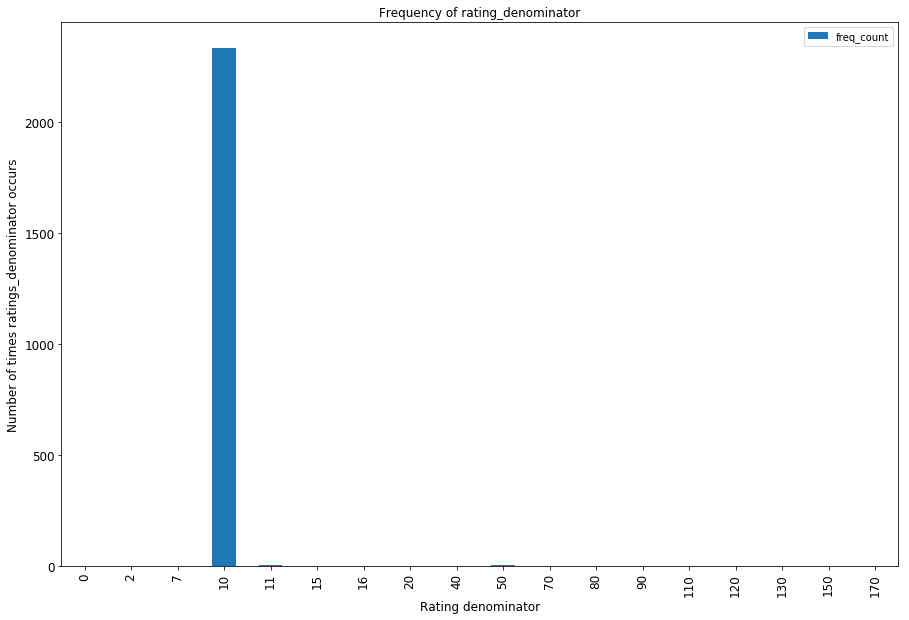

In [33]:
# Similar analysis is done for rating_denominator

rating_denominator_df = \
ax = pd.DataFrame(twitter_enhanced_df.rating_denominator.value_counts())\
.reset_index()\
.rename(columns={'index': 'rating_denominator', 'rating_denominator': 'freq_count'})\
.sort_values(by=['rating_denominator'])[['rating_denominator', 'freq_count']]\
.set_index('rating_denominator')\
.plot\
.bar(figsize=(15,10),legend=True,fontsize=12, title='Frequency of rating_denominator');

ax.set_ylabel("Number of times ratings_denominator occurs", fontsize=12)
ax.set_xlabel("Rating denominator", fontsize=12);

* In most cases `rating_denominator` value is 10
* For a handful tweets, `rating_denominator` has values like 50, 60, 70 etc
* `rating_numerator` or `rating_denominator` may not convey a lot of meaning as none of those values appear to be standardized. But the fraction `rating_numerator`/`rating_numerator` may be used for ranking dog breeds. 

Values found in rating_denominator is also recorded as an item in data cleanliness section

In [34]:
# Tweets specifying multiple dog stages in the same tweet
query_str = [
    "(doggo != 'None' and (floofer != 'None' or puppo != 'None' or pupper != 'None'))",
    "(floofer != 'None' and (doggo != 'None' or puppo != 'None' or pupper != 'None'))",
    "(puppo != 'None' and (floofer != 'None' or doggo != 'None' or pupper != 'None'))",
    "(pupper != 'None' and (floofer != 'None' or puppo != 'None' or doggo != 'None'))"
]

multiple_dog_stage_df = twitter_enhanced_df.query(' or '.join(query_str))
print("Number of tweets with multiple dog stages = %d" % len(multiple_dog_stage_df.index))
                                                         

Number of tweets with multiple dog stages = 14


In [35]:
pd.options.display.max_colwidth = 140
multiple_dog_stage_df[['tweet_id', 'text', 'doggo', 'floofer', 'puppo', 'pupper']].sample(5)

,tweet_id,text,doggo,floofer,puppo,pupper
191,855851453814013952,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for h...,doggo,None,puppo,None
778,775898661951791106,"RT @dog_rates: Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",doggo,None,None,pupper
889,759793422261743616,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MY...",doggo,None,None,pupper
705,785639753186217984,This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautio...,doggo,None,None,pupper
531,808106460588765185,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/AN...,doggo,None,None,pupper


In [36]:
twitter_enhanced_df.query('tweet_id == 808106460588765185')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
531,808106460588765185,NaN,NaN,2016-12-12 00:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/AN...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/808106460588765185/photo/1,12,10,None,doggo,None,pupper,None


Above tweet is an one example tweet which has reference to multiple dogs. 


In [37]:
'''
Strip all characters are https url string
'''
def clean_text(str):
    return re.sub(r'http://.*$', '', str)

In [38]:
'''
Finding dog stage from text
'''
def get_dog_stage(str):
    cleaned_str = clean_text(str)
    m = re.findall(r'\W+(doggo|floofer|pupper|puppo)\W+', str, re.I)
    if len(m) > 0: 
        return m[0]
    else:
        None
    
twitter_enhanced_df['derived_dog_stage'] = twitter_enhanced_df.text.apply(lambda x: get_dog_stage(x))


In [39]:
print("Records with derived dog stage = %d" % len(twitter_enhanced_df[['tweet_id', 'text', 'doggo', 'floofer', 'puppo', 'pupper', 'derived_dog_stage']]\
.query("derived_dog_stage == derived_dog_stage").index))

print("Records with given dog stage(s) = %d" % len(twitter_enhanced_df[['tweet_id', 'text', 'doggo', 'floofer', 'puppo', 'pupper', 'derived_dog_stage']]\
.query("doggo != 'None' or floofer != 'None' or puppo != 'None' or pupper != 'None'")\
.index))
       

Records with derived dog stage = 376
Records with given dog stage(s) = 380


Above analysis shows that the given classification of dog stage didn't miss out identifying it if it appeared somewhere in the tweet text.

In [40]:
'''
Get rating numerator & denominator from text using regular expression
'''
def parse_ratings(str):
    cleaned_str = clean_text(str)
    m = re.search(r'.*?(\d+\.?\d*)\s*/\s*(\d+\.?\d*)', cleaned_str)

    if m is not None:
        return m.group(1), m.group(2)
    else:
        return None, None
    

In [41]:
# Add two new fields to the dataframe 
twitter_enhanced_df['rating_num'], twitter_enhanced_df['rating_den'] = zip(*twitter_enhanced_df['text'].map(parse_ratings))

# Convert ratings fields to float data type
for col in ['rating_numerator', 'rating_denominator', 'rating_num', 'rating_den']:
    twitter_enhanced_df[col] = twitter_enhanced_df[col].apply(lambda x: float(x))

In [42]:
# Match whether given rating fields match with parsed rating values from text fields
twitter_enhanced_df.query("rating_numerator != rating_num or rating_denominator != rating_den")\
[['tweet_id', 'text', 'rating_numerator', 'rating_denominator', 'rating_num', 'rating_den']]


,tweet_id,text,rating_numerator,rating_denominator,rating_num,rating_den
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5.0,10.0,13.50,10.0
340,832215909146226688,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO...",75.0,10.0,9.75,10.0
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75.0,10.0,9.75,10.0
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile bac...,27.0,10.0,11.27,10.0
1689,681340665377193984,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,5.0,10.0,9.50,10.0
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26.0,10.0,11.26,10.0


In [43]:
twitter_enhanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 20 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null float64
rating_denominator            2356 non-null float64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
derived_dog_stage           

Observation from above is: 

* `rating_numerator` and `rating_denominator` field values are mostly correct except in cases where given rating was a floating point number e.g. 13.5/10 for tweet ID = 883482846933004288 Instead of `numerator = 13.5` and `denomintaor=10.0` the given data file misidentified as `5/10` This is noted as a data cleanliness issue

I plan to use the metric `rating_numerator / rating_denominator` for ranking dog breed and dog stages. For that to work correctly I need to check that `rating_denominator != 0`. In such a line is found, that line needs to be removed from final daatset.

In [44]:
# Checking if rating_denominator is zero for any tweet
twitter_enhanced_df.query("rating_denominator == 0")

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,derived_dog_stage,rating_num,rating_den
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,NaN,NaN,NaN,960.0,0.0,None,None,None,None,None,None,960.0,0.0


There is one such record. Tweet ID = 835246439529840640 This needs to be removed from final dataset. Removal of this tweet may serve as removing an outlier in `rating_numerator`

Cleanliness of `twitter_enhanced_df`
* timestamp column values should not have trailing +00000
* `source` can't used for data analysis purpose as it contains html text with "a href" string
* Some records correspond to retweet. They need to be removed.
* Some records correspond to replies. They need to be removed
* For few records `rating_numerator` & `ratings denominator` contain incorrect rating values. These happened for where the ratings numerator or denominator in original text had floating point numbers.   
* `rating_denominator` is zero for tweet ID = 835246439529840640. That needs to be removed.
* As noted during visual analysis, some values in `name` appear to be dirty. 
* There are tweets with multiple dog stages for a single dog e.g. doggo & pupper



Structural issue in `twitter_enhanced_df`
- timestamp column should be a `datetime` field instead of string so it can be used for analysis
- rating fields need to be float to accomodate decimal values for ratings
- Instead of having 4 columns for classification of dogs based on dogtionary, it is useful to have a column named `dog_type` and maintain categorical values there.
- I started with 3 data sources. Two of which are downloaded using Python `requests` object while the third one is downloaded using API calls. I had built three dataframes - each for one source. For analysis purpose, it will be beneficial to have a single dataframe having tweet ID, tweet timestamp, dog ratings, dog classification and dog identification information


In [45]:
prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


Cleanliness of `prediction_df`

* Some entries refer to pictures other than dogs.
* This dataframe does not have picture of all dog related tweets in `twitter_enhanced_df`

Structural issue in `prediction_df`

* It may be easier to deal with only one dog classification based on highest confidence rating
* For analysis purpose, it will be beneficial to have a single dataframe having combining `prediction_df` and `twitter_enhanced_df`

In [46]:
tweet_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 5 columns):
favorite_count     2340 non-null int64
followers_count    2340 non-null int64
retweet_count      2340 non-null int64
source             2340 non-null object
tweet_id           2340 non-null int64
dtypes: int64(4), object(1)
memory usage: 91.5+ KB


Structural issue in tweet_data_df

* This dataframe needs to be combined with other two dataframe before the final analysis

Summary of issues:

* Cleanliness Issue
    - timestamp column values should not have trailing +00000
    - `source` can't used for data analysis purpose as it contains html text with "a href" string
    - Some records correspond to retweet. They need to be removed.
    - Some records correspond to replies. They need to be removed.
    - Not all tweets have related dog picture or some tweets have objects other than dog.
    - For few records rating_numerator & ratings denominator contain incorrect rating values. These happened for where the ratings numerator or denominator in original text had floating point numbers. 
    - `rating_denominator` is zero for tweet ID = 835246439529840640. That needs to be removed.
    - `ratings_numerator` contains incorrect value specially when the text containing the rating uses floating point number for ratings
    - There are tweets with multiple dog stages for a single dog e.g. doggo & pupper
    
* Structural Issue
    - All three dataframes need to be combined together for ease of analysis
    - Use only one dog classification form `prediction_df` with highest confidence value
    - Change `timestamp` column in `twitter_enhanced_df` to datetime data type
    - Change `rating` fields in `twitter_enhanced_df` to float data type
    - Instead of 4 `dog_stage` fields in `twitter_enhanced_df`, use only one column for categorical values
    
    

## Cleaning

In [47]:
twitter_enhanced_df.drop(['derived_dog_stage'], axis=1, inplace=True)
# Copy into a new data frame
cleaned_twitter_df = twitter_enhanced_df.copy()

### Issue

<b>Trailing `0000` in `timestamp` field in `twitter_enhanced_df` </b>

### Action

Remove `0000` from timestamp field

### Code

In [48]:
cleaned_twitter_df.timestamp.head()

0    2017-08-01 16:23:56 +0000
1    2017-08-01 00:17:27 +0000
2    2017-07-31 00:18:03 +0000
3    2017-07-30 15:58:51 +0000
4    2017-07-29 16:00:24 +0000
Name: timestamp, dtype: object

In [49]:
cleaned_twitter_df.timestamp.str.endswith('+0000').sum()

2356

In [50]:
cleaned_twitter_df['timestamp'] = cleaned_twitter_df.timestamp.apply(lambda x: re.sub(r'\s+\+0000', '', x))

### Test

In [51]:
print("Number of records with trailing 0000 in timestamp field = %d" % 
      cleaned_twitter_df.timestamp.str.endswith('+0000').sum())

Number of records with trailing 0000 in timestamp field = 0


### Issue

<b>There is one tweet having`rating_denominator=0` </b>

### Action

Remove that record from final dataframe

### Code

In [52]:
# Delete the tweet having rating_denominator = 0
cleaned_twitter_df = cleaned_twitter_df.drop(cleaned_twitter_df.query("rating_denominator == 0").index, axis=0)


### Test

In [53]:
print("Number of tweet with zero as rating_denominator = %d" \
      % len(cleaned_twitter_df.query("rating_denominator == 0").index))

Number of tweet with zero as rating_denominator = 0


### Issue

<b>`rating_numerator` values are incorrect when tweet text uses floating point numbers </b>

### Action

Parse rating from text. Fix numerator and denominator values.

### Code

In [54]:
def compute_rating(row):
    if row['rating_num'] is not None and row['rating_den'] is not None:
        return row['rating_num'] / row['rating_den']
    else:
        return None

In [55]:
cleaned_twitter_df['rating'] = cleaned_twitter_df.apply(lambda row: compute_rating(row), axis=1)


### Test

In [56]:
cleaned_twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2355 entries, 0 to 2355
Data columns (total 20 columns):
tweet_id                      2355 non-null int64
in_reply_to_status_id         77 non-null float64
in_reply_to_user_id           77 non-null float64
timestamp                     2355 non-null object
source                        2355 non-null object
text                          2355 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2355 non-null float64
rating_denominator            2355 non-null float64
name                          2355 non-null object
doggo                         2355 non-null object
floofer                       2355 non-null object
pupper                        2355 non-null object
puppo                         2355 non-null object
rating_num                  

In [57]:
rating_df = cleaned_twitter_df.query("rating_numerator != rating_num or rating_denominator != rating_den")
print("Number of tweets in which newly computed ratings don't match with given ratings = %d" % len(rating_df.index))


Number of tweets in which newly computed ratings don't match with given ratings = 6


In [58]:
# Visual assessment of these records shows rating_num & rating_den are computed correctly
rating_df[['tweet_id', 'text', 'rating_numerator', 'rating_denominator', 'rating_num', 'rating_den']].head(6)

,tweet_id,text,rating_numerator,rating_denominator,rating_num,rating_den
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5.0,10.0,13.50,10.0
340,832215909146226688,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO...",75.0,10.0,9.75,10.0
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75.0,10.0,9.75,10.0
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile bac...,27.0,10.0,11.27,10.0
1689,681340665377193984,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,5.0,10.0,9.50,10.0
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26.0,10.0,11.26,10.0


In [59]:
# Drop the columns from final dataframe
cleaned_twitter_df.drop(['rating_numerator', 'rating_denominator', 'rating_num', 'rating_den'], axis=1, inplace=True)

In [60]:
# Confirm that there is only one rating column
cleaned_twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2355 entries, 0 to 2355
Data columns (total 16 columns):
tweet_id                      2355 non-null int64
in_reply_to_status_id         77 non-null float64
in_reply_to_user_id           77 non-null float64
timestamp                     2355 non-null object
source                        2355 non-null object
text                          2355 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
name                          2355 non-null object
doggo                         2355 non-null object
floofer                       2355 non-null object
pupper                        2355 non-null object
puppo                         2355 non-null object
rating                        2355 non-null float64
dtypes: float64(5), int64(1), object(10)
memory usage: 312.8+ KB


### Issue

<b>`source` can't used for data analysis purpose as it contains html text with "a href" string</b>

### Action|

Drop this column from `cleaned_twitter_df`. This data element has already been added to `tweet_data_df` dataframe.

### Code

In [61]:
cleaned_twitter_df.drop(['source'], axis=1, inplace=True)

### Test

In [62]:
# Examine source field in tweet_data_df. These values appear to be clean.
tweet_data_df.source.value_counts()

iphone       2206
scene          91
client         33
tweetdeck      10
Name: source, dtype: int64

In [63]:
cleaned_twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2355 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id                      2355 non-null int64
in_reply_to_status_id         77 non-null float64
in_reply_to_user_id           77 non-null float64
timestamp                     2355 non-null object
text                          2355 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
name                          2355 non-null object
doggo                         2355 non-null object
floofer                       2355 non-null object
pupper                        2355 non-null object
puppo                         2355 non-null object
rating                        2355 non-null float64
dtypes: float64(5), int64(1), object(9)
memory usage: 294.4+ KB


### Issue
<b>`timestamp` field is `string` data type</b>

### Action
Change data type to datetime


### Code

In [64]:
cleaned_twitter_df['timestamp'] = pd.to_datetime(cleaned_twitter_df.timestamp, format='%Y-%m-%d %H:%M:%S')

### Test

In [65]:
cleaned_twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2355 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id                      2355 non-null int64
in_reply_to_status_id         77 non-null float64
in_reply_to_user_id           77 non-null float64
timestamp                     2355 non-null datetime64[ns]
text                          2355 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
name                          2355 non-null object
doggo                         2355 non-null object
floofer                       2355 non-null object
pupper                        2355 non-null object
puppo                         2355 non-null object
rating                        2355 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(1), object(8)
memory usage: 294.4+ KB


### Issue
<b>4 columns represent `dog_stage` in `twitter_enhanced_df`</b>

### Action
Combine the categorical variable into a single column and name the column as `dog_stage`

### Code

In [66]:
'''
Combines 4 dog_stage columns into one.
If a dog is having more than one dog_stage only the first one is picked up
'''
def combine_dog_stages(row):
    if row['doggo'] != 'None': return row['doggo']
    elif row['floofer'] != 'None': return row['floofer']
    elif row['pupper'] != 'None': return row['pupper']
    elif row['puppo'] != 'None': return row['puppo']
    else: return None
    
cleaned_twitter_df['dog_stage'] = \
cleaned_twitter_df.apply(combine_dog_stages, axis=1)
cleaned_twitter_df.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

### Test

In [67]:
cleaned_twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2355 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id                      2355 non-null int64
in_reply_to_status_id         77 non-null float64
in_reply_to_user_id           77 non-null float64
timestamp                     2355 non-null datetime64[ns]
text                          2355 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
name                          2355 non-null object
rating                        2355 non-null float64
dog_stage                     380 non-null object
dtypes: datetime64[ns](1), float64(5), int64(1), object(5)
memory usage: 239.2+ KB


### Issue
<b>`cleaned_twitter_df` contains retweet data</b>

### Action
Remove retweet data

### Code

In [68]:
cleaned_twitter_df = cleaned_twitter_df[cleaned_twitter_df.retweeted_status_id.isnull()]

### Test

In [69]:
print("Number of retweet entries = %d" % len(cleaned_twitter_df[cleaned_twitter_df.retweeted_status_id > 0].index))

Number of retweet entries = 0


### Issue
<b>`cleaned_twitter_df` contains tweet replies</b>

### Action
Remove reply tweets

### Code

In [70]:
print("Number of replies before deletion of replies = %d" % len(cleaned_twitter_df[cleaned_twitter_df.in_reply_to_status_id > 0].index))

cleaned_twitter_df = cleaned_twitter_df[cleaned_twitter_df.in_reply_to_status_id.isnull()]

Number of replies before deletion of replies = 77


### Test

In [71]:
print("Number of replies after deletion of replies = %d" % len(cleaned_twitter_df[cleaned_twitter_df.in_reply_to_status_id > 0].index))


Number of replies after deletion of replies = 0


### Issue
<b>Prediction dataframe contains pictures of objects other than dogs</b>

I perform another round of quick visual assessment by opening up the picture links in browser. For example - https://twitter.com/dog_rates/status/671511350426865664/photo/1 This is not the picture of a dog. These tweets need to be removed.

### Action
Remove those entries from prediction dataframe

### Code

In [72]:
cleaned_prediction_df = prediction_df.copy()
print("Number of records in prediction dataframe = %d" % len(cleaned_prediction_df.index))

Number of records in prediction dataframe = 2075


In [73]:
cleaned_prediction_df = cleaned_prediction_df.query("p1_dog == True or p2_dog == True or p3_dog == True")

### Test

In [74]:
# No entry found which doesn;t have at least dog image
len(cleaned_prediction_df.query("p1_dog == False and p2_dog == False and p3_dog == False").index)


0

### Issue
There are 3 predictions for every dog image

### Action
Combine them into a single column

### Code

In [75]:

def combine_prediction(row):
    if row['p1_dog'] == True:
        return row.p1
    elif row['p2_dog'] == True:
        return row.p2
    else:
        return row.p3
    


In [76]:
cleaned_prediction_df['dog'] = cleaned_prediction_df.apply(lambda row: combine_prediction(row), axis=1)

### Test

In [77]:
# Confirm new column `dog` exists
cleaned_prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 0 to 2073
Data columns (total 13 columns):
tweet_id    1751 non-null int64
jpg_url     1751 non-null object
img_num     1751 non-null int64
p1          1751 non-null object
p1_conf     1751 non-null float64
p1_dog      1751 non-null bool
p2          1751 non-null object
p2_conf     1751 non-null float64
p2_dog      1751 non-null bool
p3          1751 non-null object
p3_conf     1751 non-null float64
p3_dog      1751 non-null bool
dog         1751 non-null object
dtypes: bool(3), float64(3), int64(2), object(5)
memory usage: 155.6+ KB


In [78]:
# Value in `dog` column must match one of p1_dog, p2_dog or p3_dog
cleaned_prediction_df.query("dog != p1 and dog != p2 and dog != p3")

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog


In [79]:
# Drop columns which will not be used for analysis
cleaned_prediction_df.drop(['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], axis=1, inplace=True)


### Issue
<b>There are tweets without dog picture</b>

### Action
Remove those tweets

In [80]:
# Find out the tweets which are without pictures
combined_df = cleaned_twitter_df.merge(cleaned_prediction_df, how='left', indicator=True, on='tweet_id').reset_index()
combined_df = combined_df[combined_df['_merge'] == 'both']
print("Number of tweets having dog image = %d" % len(combined_df))

Number of tweets having dog image = 1666


In [81]:
#Remove the tweets which don't have matching picture
cleaned_twitter_df = cleaned_twitter_df[cleaned_twitter_df.tweet_id.isin(combined_df.tweet_id)]


### Test

In [82]:
# Left outer join with cleaned tweets with prediction data
test_df = cleaned_twitter_df.merge(cleaned_prediction_df, how='left', indicator=True, on='tweet_id').reset_index()
# Check for data coming tweet file but not from prediction. These will be tweets without images
# No such rows found
test_df[test_df['_merge'] == 'left_only']


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,name,rating,dog_stage,jpg_url,img_num,dog,_merge


### Issue
<b>There needs to be one final cleaned dataset for ease of analysis instead of 3 dataframes</b>

### Action
Join `combined_df` with `tweet_data_df`

### Code


In [83]:
twitter_master_df = \
combined_df[['tweet_id', 'timestamp', 'rating', 'dog_stage', 'dog', 'text']]\
.merge(tweet_data_df, on='tweet_id')\
.reset_index()

## More wrangling before storing data

Reading through the tweets, I find most of the tweets references dog's gender in subtle fashion. It can be derived parsing the tweet `text` and looking for pronouns like `He` or `She`. The gender of the dog can give us valuable insights like 
* Which gender gets more `likes`
* Which gender gets more `retweet`


In [84]:
'''
Gender classification of dog based on the usage of pronoun in tweet text
'''
def get_gender(str):
    cleaned_str = re.sub(r'http:.*$','', str)
    if re.search(r'\.{0,1}\s*He\s*|\s+[H|h]is\s+', cleaned_str):
        return 'Male'
    elif re.search(r'\.{0,1}\s*She\s*|\s+[H|h]er\s+', cleaned_str):
        return 'Female'
    else:
        return 'Unknown'

# Add gender to dataframe
twitter_master_df['gender'] = twitter_master_df.text.apply(lambda x: get_gender(x))

In [85]:
# Change all dog breeds to lower case
twitter_master_df = twitter_master_df.assign(dog_breed = lambda x: x.dog.str.lower())

In [86]:
twitter_master_df.drop(['text', 'dog'], axis=1, inplace=True)

## Store

In [87]:
# Save the final dataframe as csv
twitter_master_df.to_csv('data/twitter_archive_master.csv', index=False)

## Analyze

I start by comparing likes by gender to see if this data tells me any story whether male or female dogs got higher likes.

In [88]:
twitter_master_df[['favorite_count', 'tweet_id', 'gender']]\
.groupby('gender')\
.agg({'favorite_count' : 'sum', 'tweet_id': 'count'})\
.reset_index()\
.rename(columns={'tweet_id': 'dog_count'})

,gender,favorite_count,dog_count
0,Female,2946952,275
1,Male,8761330,930
2,Unknown,3392715,459


The above snippet shows number of male dogs in this dataset is significantly higher than female dogs. So comparing total value of `likes` will be misleading. Instead of `sum`, I decided to use `median` value.

In [89]:
twitter_master_df[['favorite_count', 'tweet_id', 'gender']]\
.groupby('gender')\
.agg({'favorite_count' : 'median', 'tweet_id': 'count'})\
.reset_index()\
.rename(columns={'tweet_id': 'dog_count'})

,gender,favorite_count,dog_count
0,Female,5727.0,275
1,Male,4653.5,930
2,Unknown,3234.0,459


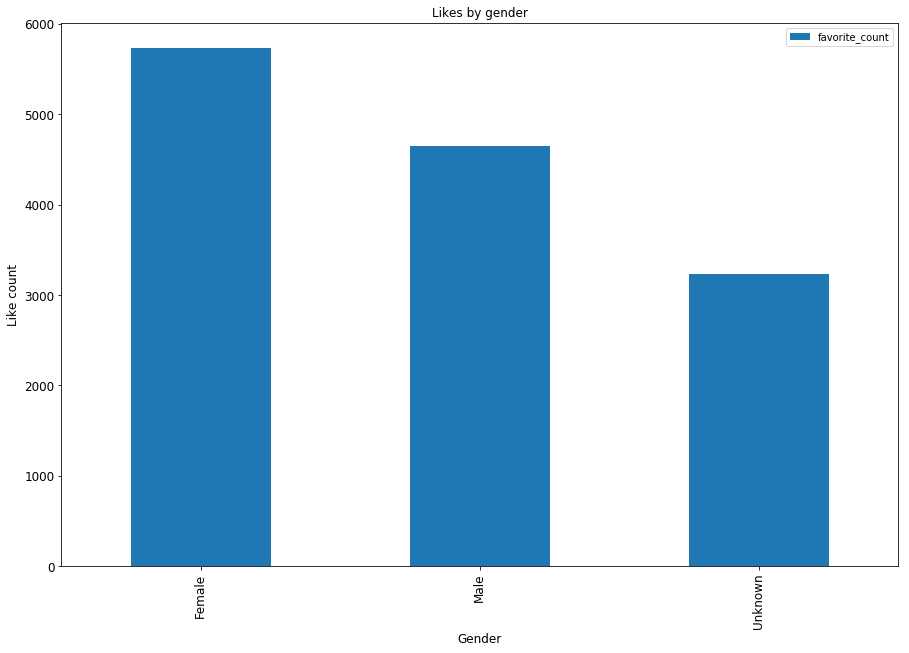

In [90]:
# Analysis of number of likes by gender
ax = twitter_master_df[['favorite_count', 'gender']]\
.groupby('gender')\
.agg({'favorite_count' : 'median'})\
.reset_index()\
.set_index('gender')\
.plot\
.bar(figsize=(15,10),legend=True,fontsize=12, title='Likes by gender');

ax.set_ylabel("Like count", fontsize=12)
ax.set_xlabel("Gender", fontsize=12);


The bar graph indicates that "like" count is higher for female dogs rather than male dogs. Gender of dog is a derived field based on the use of pronoun in tweet text. 


Continuing the same analysis, I add another metric - `retweet count`. This is a metric indicating how many times the tweet has been retweeted and is a metric that can be used as a measure of popularity of the image.

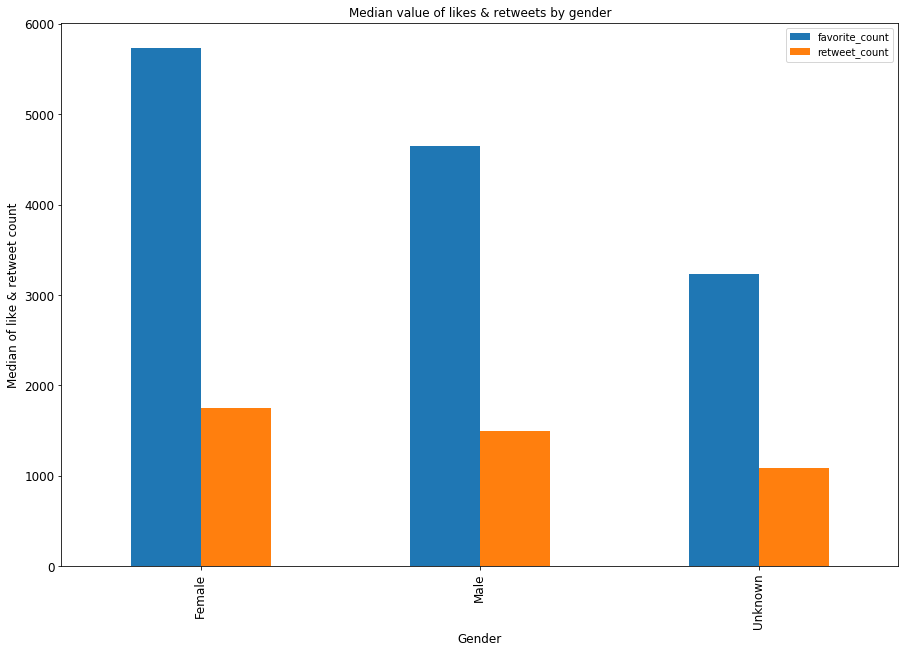

In [91]:
# Analysis of number of likes & retweets by gender
ax = twitter_master_df[['favorite_count', 'retweet_count', 'gender']]\
.groupby('gender')\
.agg({'favorite_count' : 'median', 'retweet_count': 'median'})\
.reset_index()\
.set_index('gender')\
.plot\
.bar(figsize=(15,10),legend=True,fontsize=12, title='Median value of likes & retweets by gender');

ax.set_ylabel("Median of like & retweet count", fontsize=12)
ax.set_xlabel("Gender", fontsize=12);

Here again I observe that number of retweets for female dogs is higher than male dogs.

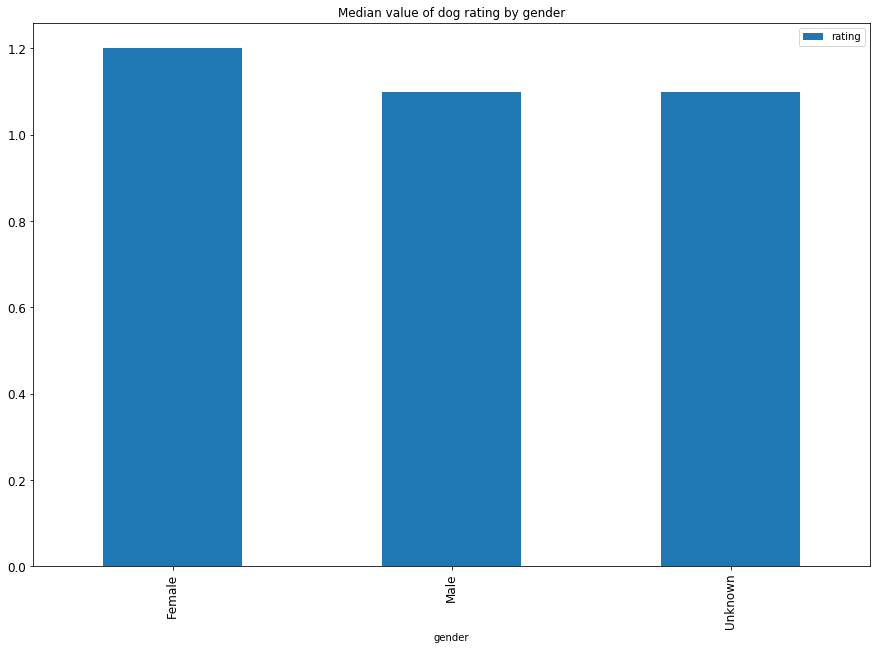

In [92]:
# Analysis of ratings by gender
twitter_master_df[['rating', 'gender']]\
.groupby('gender')\
.agg({'rating' : 'median'})\
.reset_index()\
.set_index('gender')\
.plot\
.bar(figsize=(15,10),legend=True,fontsize=12, title='Median value of dog rating by gender');

ax.set_ylabel("Median dog rating", fontsize=12)
ax.set_xlabel("Gender", fontsize=12);

In the above plot, the median value of rating for female dog slightly higher than male dog.

`retweet_count` indicates number of retweets of the given tweet
`favorite_count` indicates number of likes of the tweet

I wanted to explore if data shows any corelation between these metrics as well as `ratings` of dog. I used `seaborn` pairplot for visualization. Followed by that I used Pandas to compute correlation using Pearson method. `retweet_count` and `faviorite_count` has strong correlation with `r = 0.93`

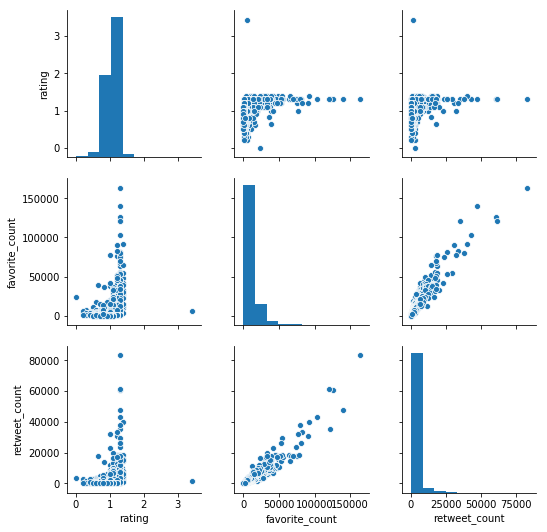

In [93]:
metric_df = twitter_master_df[['rating', 'favorite_count', 'retweet_count']]
import seaborn as sns
sns.pairplot(metric_df);

In [94]:
twitter_master_df[['favorite_count', 'retweet_count']].corr(method='pearson')

,favorite_count,retweet_count
favorite_count,1.000000,0.931524
retweet_count,0.931524,1.000000


In [95]:
twitter_master_df[['favorite_count', 'rating']].corr(method='pearson')

,favorite_count,rating
favorite_count,1.000000,0.382252
rating,0.382252,1.000000


In [96]:
twitter_master_df['rating'].describe()

count    1664.000000
mean        1.082609
std         0.188393
min         0.000000
25%         1.000000
50%         1.100000
75%         1.200000
max         3.428571
Name: rating, dtype: float64

Median value of dog rating is 1.1. Dog rating is a continuous quantitative variable. I plan to analyze to see if this data set shows any relationship between rating & likes.

To perform that analysis, I bucketize `rating` column. The new column is named `rating_bucket`.

In [97]:
# Keeping only two places after decimal for rating
twitter_master_df['rating_bucket'] = twitter_master_df.rating.apply(lambda x: round(x, 2))

The following snippet computes median value of `likes` for every `rating_bucket`. For `rating_bucket` having less than 10 dogs, I decide to exclude those buckets from analysis as they can bias the analysis.

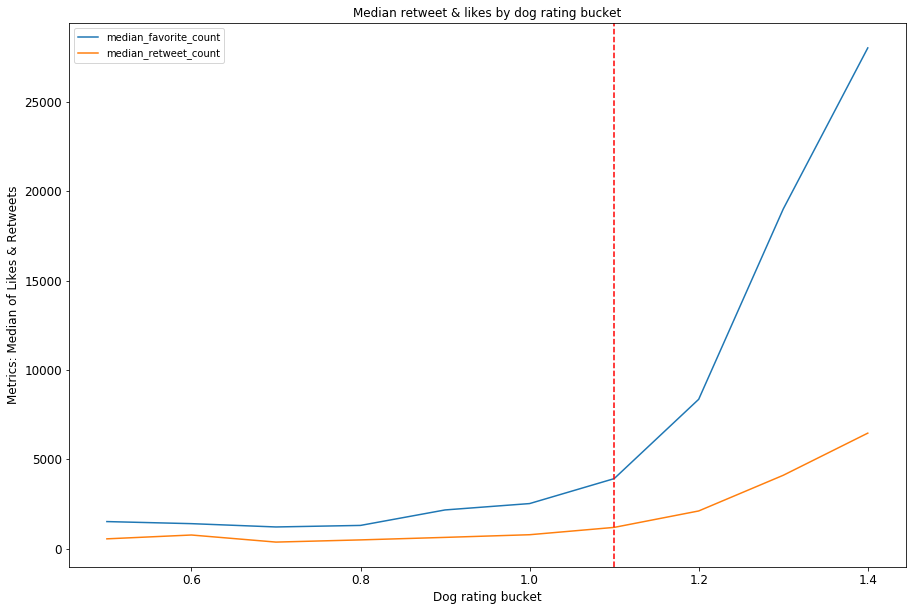

In [98]:
ax = twitter_master_df[['rating_bucket', 'tweet_id', 'favorite_count', 'retweet_count']]\
.groupby('rating_bucket')\
.agg({'tweet_id': 'count', 'favorite_count': 'median', 'retweet_count' : 'median'})\
.reset_index()\
.rename(columns={'tweet_id': 'dog_count', 'favorite_count': 'median_favorite_count', 'retweet_count' : 'median_retweet_count'})\
.query("dog_count >= 10")[['rating_bucket', 'median_favorite_count', 'median_retweet_count']]\
.set_index('rating_bucket')\
.plot\
.line(figsize=(15,10),legend=True,fontsize=12, title='Median retweet & likes by dog rating bucket');

ax.set_ylabel("Metrics: Median of Likes & Retweets", fontsize=12)
ax.set_xlabel("Dog rating bucket", fontsize=12);
ax.axvline(1.1, color='red', linestyle='--');


Plot of median value of `likes` & `retweets` shows an upward trend of likes & retweet for dogs having more than median rating (1.1)

Next step is to explore if median value of `likes` and `tweets` exhibit any temporal trend

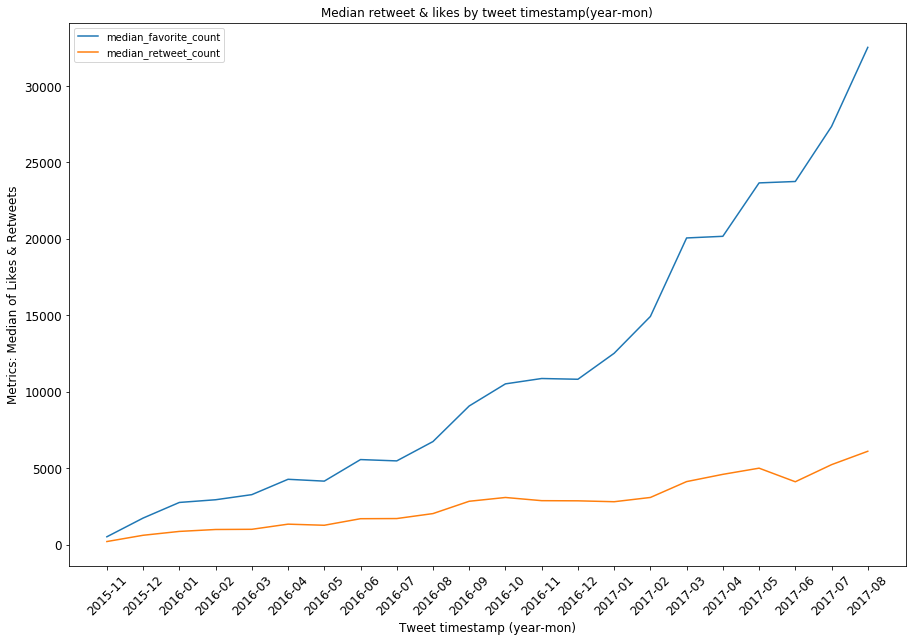

In [99]:
twitter_master_df['tweet_yr_mon'] = twitter_master_df.timestamp.apply(lambda x: x.strftime('%Y-%m'))

df = twitter_master_df[['tweet_yr_mon', 'tweet_id', 'favorite_count', 'retweet_count']]\
.groupby('tweet_yr_mon')\
.agg({'favorite_count': 'median', 'retweet_count' : 'median'})\
.reset_index()\
.rename(columns={'favorite_count': 'median_favorite_count', 'retweet_count' : 'median_retweet_count'})\
.set_index('tweet_yr_mon')

ax = df.plot(figsize=(15,10),
             legend=True,
             fontsize=12, 
             rot=45,
             title='Median retweet & likes by tweet timestamp(year-mon)');

ax.set_ylabel("Metrics: Median of Likes & Retweets", fontsize=12)
ax.set_xlabel("Tweet timestamp (year-mon)", fontsize=12);
ax.set_xticks([i for i, x in enumerate(df.index)])
ax.set_xticklabels(df.index);


## References

<ol>
    <li><a href="https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object.html">Twitter API documentation</a></li>
    <li><a href="http://pandas.pydata.org/pandas-docs/stable/">Panda documentation</a></li>
    <li><a href="https://stackoverflow.com/questions/39714724/pandas-plot-x-axis-tick-frequency-how-can-i-show-more-ticks">Stackoverflow discussion on x-labels and x-ticks</a></li>
</ol>